In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import pickle
from tqdm.auto import trange, tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_train.pkl', 'rb') as f:
    dnn_train = pickle.load(f)

In [4]:
class TemporalAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(TemporalAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(TemporalAttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W))
        alpha = K.softmax(e, axis=1)
        # 변경: 원래 시퀀스와 가중치를 곱하여 출력 형태를 유지
        context = x * alpha
        return context

    def compute_output_shape(self, input_shape):
        return input_shape


In [5]:
dnn_model = load_model('/content/drive/MyDrive/학교/스마트교차로/dnn_model.h5')

lstm_model = load_model('/content/drive/MyDrive/학교/스마트교차로/lstm_model.h5', custom_objects={'TemporalAttentionLayer': TemporalAttentionLayer})

weather_data = pd.read_csv('/content/drive/MyDrive/학교/스마트교차로/weather.csv',encoding='cp949')

# LSTM to DNN의 Loss 및 정확도 확인

In [6]:
with open('/content/drive/MyDrive/학교/스마트교차로/lstm_val_X.pkl', 'rb') as f:
    lstm_val_X = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/lstm_val_y.pkl', 'rb') as f:
    lstm_val_y = pickle.load(f)

In [7]:
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_val_X.pkl', 'rb') as f:
    dnn_val_X = pickle.load(f)
with open('/content/drive/MyDrive/학교/스마트교차로/dnn_val_y.pkl', 'rb') as f:
    dnn_val_y = pickle.load(f)

In [8]:
lstm_output = pd.DataFrame(lstm_model.predict(lstm_val_X[34:]))
con_weather =weather_data.iloc[4031:len(weather_data)-1].reset_index(drop=True)
result = pd.concat([lstm_output,con_weather],axis=1)
result = pd.concat([result]*6,axis=0).reset_index(drop=True)
dnn_input = pd.concat([result, dnn_val_X.iloc[:,-8:]], axis=1)
dnn_input

12/12 [==============================] - 8s 11ms/step


,0,1,2,3,4,5,6,7,8,9,...,적설(cm),지면온도(°C),holi_day,sign_1,sign_2,sign_3,sign_4,sign_5,sign_6,direction
0,110.717407,155.303314,212.307404,130.436752,82.938828,58.931931,177.208282,37.029583,142.008286,79.483604,...,0.0,16.5,0,24,31,20,17,17,17,0
1,77.467697,120.579224,165.077805,92.523575,61.628731,40.136799,136.182709,27.742661,96.854088,53.843063,...,0.0,16.3,0,24,31,20,17,17,17,0
2,64.742256,102.732826,149.429749,77.947342,53.744858,33.804317,118.261269,21.323423,79.089020,46.245678,...,0.0,16.1,0,24,31,20,17,17,17,0
3,57.625904,89.778862,150.629883,73.791618,45.705021,29.380453,104.339027,17.473738,81.471703,43.831127,...,0.0,15.8,0,24,31,20,17,17,17,0
4,55.518047,79.400452,154.757248,81.527992,46.204910,27.289482,104.586334,17.402464,101.140610,51.469074,...,0.0,15.6,0,24,31,20,17,17,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,331.618347,411.392303,545.350830,430.495148,282.528015,191.979279,567.460327,76.924011,381.644104,217.970612,...,0.0,18.9,0,31,31,23,26,19,26,5
2300,304.100769,353.663147,501.706970,371.850037,249.009140,170.018127,504.850830,77.685684,336.751404,195.915390,...,0.0,17.6,0,31,31,23,26,19,26,5
2301,282.184021,300.828094,471.392365,320.472565,213.297943,156.800949,447.303284,78.672180,306.580078,183.124924,...,0.0,17.1,0,24,31,20,17,17,17,5
2302,226.932724,230.261475,384.840637,242.408371,158.948822,126.948708,348.442871,66.574608,249.053085,149.920273,...,0.0,16.7,0,24,31,20,17,17,17,5


72/72 [==============================] - 0s 3ms/step


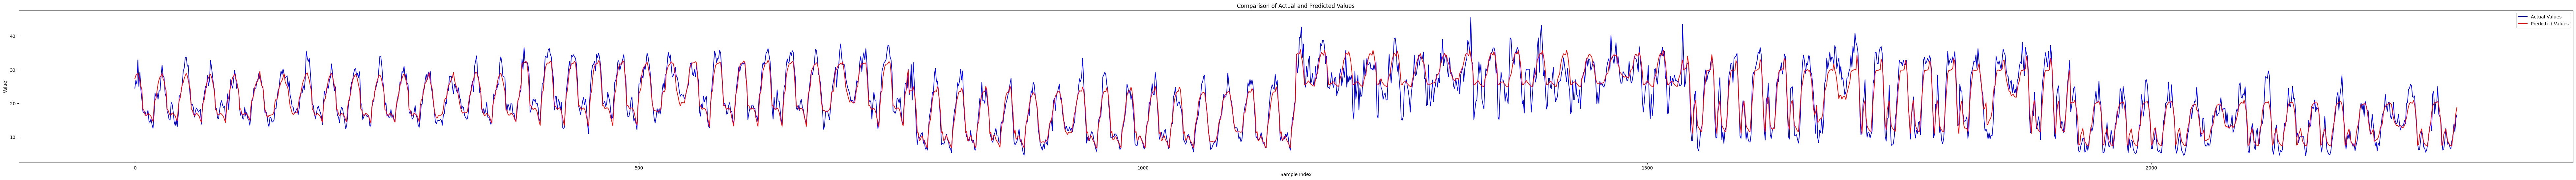

In [9]:
# 모델을 사용하여 예측 수행
predicted_y_test = dnn_model.predict(dnn_input)

# 실제 값과 예측값을 선 그래프로 표시
plt.figure(figsize=(100, 6))
plt.plot(dnn_val_y, label='Actual Values', color='blue')
plt.plot(predicted_y_test, label='Predicted Values', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [10]:
loss_and_metrics = dnn_model.evaluate(dnn_input, dnn_val_y, batch_size = 32)
print('loss: ', loss_and_metrics)

72/72 [==============================] - 2s 3ms/step - loss: 8.3139
loss:  8.313865661621094


# 실험 결과 속도 비교

In [18]:
with open('/content/실험결과.pkl', 'rb') as f:
    result = pickle.load(f)

In [13]:
# 2023년 10월 16일: 각 시간별 평균 속도
avg_speed = [26.935183990607, 27.3492730760164, 28.1393290102559, 28.915997245113, 29.8499517528896, 28.471, 25.736, 23.002, 19.234, 18.787, 18.953, 18.596, 19.146, 19.228, 18.592, 18.304, 17.96, 16.878, 16.517, 18.925, 21.114, 21.938, 23.342, 25.29]

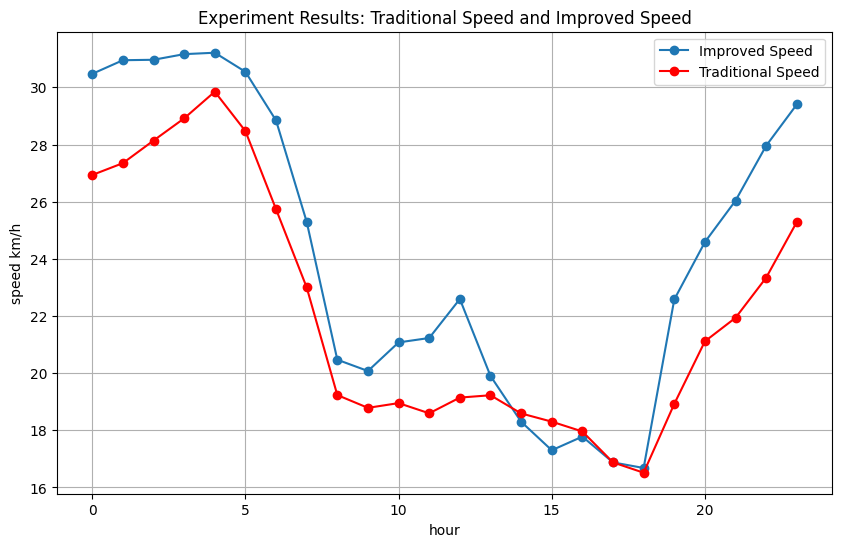

In [33]:
second_elements = [t[1] for t in result]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(second_elements, marker='o', label='Improved Speed')
plt.plot(avg_speed, marker='o',color ='red', label='Traditional Speed')
plt.title('Experiment Results: Traditional Speed and Improved Speed')
plt.xlabel('hour')
plt.ylabel('speed km/h')
plt.grid(True)
plt.legend()
plt.show()